# Predicting Heart Disease: DSCI 100 Group Project Report  (Group 23)

### Introduction:

Cardiovascular diseases (CVDs), or heart diseases, encompasses a range of medical conditions that affect the heart and blood vessels. Worldwide, CVDs are the leading cause of death with nearly 18 million deaths a year (World Health Organization, 2023). Early detection is key to treatment, prevention, and management of heart disease; this data analysis aims to create an algorithm which can be used to assist with this process.

The dataset used is from: https://archive.ics.uci.edu/dataset/45/heart+disease. The data was published in 1988 and the dataset we are using is the one specifically collected in Cleveland. The dataset consists of 303 observations and 14 variables.

The question we aim to address is: **can we predict if a patient has heart disease based on their age, resting blood pressure, serum cholesterol, and maximum resting heart rate?**

We will use the k-nearest neighbor classification model to predict heart disease.

### Methods & Results:

First we load in the required libraries into this Jupyter notebook so that we can use it to edit, wrangle and visualize any data. We also import the `RColorBrewer` library so that we can make our plots color-blind friendly.

In [1]:
library(tidyverse)
library(RColorBrewer)
library(tidymodels)
library(repr)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

We downloaded the dataset from Kaggle and uploaded it to a remote repistory (GitHub). This makes the dataset reproducible. The code below downloads the dataset from the remote repository into this notebook which is the local repository. Then we read the csv file that is downloaded.

In [2]:
#These lines of code bring the data into R and make it into a table showing the first 5 rows
download.file("https://raw.githubusercontent.com/Aamitoz-Sharma/Group_23_project/main/heart.csv", "heart_data.csv") #downloading file
heart_data <- read_csv("heart_data.csv")
head(heart_data)


Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


Next, we wrangle the dataset. First we use `select` to only obtain the coloumns that we are interested in i.e. the categorical variable we want to predict and the predictors. Then we use `mutate` to change the datatype of the variable that we want to predict (`HeartDisease`) into a categorical variable(`fct`) so that we can use it in our k-nn classification model. We also change the numbers in `HeartDisease` from 0 and 1 to "yes" and "no" so that it is easier to understand.

In [3]:
#This set of data will select the data points we are interested in Age, Resting blood pressure, Cholesterol, Max heart rate and Heart Disease
heart <- heart_data |> 
    select(Age, RestingBP, Cholesterol, MaxHR, HeartDisease) |>
#This line changes the Heart Disease variable from a continous quantitative variable(dbl) to a categorical variable(fct)
    mutate(HeartDisease = as_factor(HeartDisease)) |>
#This line changes the factor variables from 0 to no and 1 to yes
    mutate(HeartDisease = fct_recode(HeartDisease, "yes" = "1", "no" = "0")) 
head(heart)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,no
49,160,180,156,yes
37,130,283,98,no
48,138,214,108,yes
54,150,195,122,no
39,120,339,170,no


The following code splits the dataset into training and testing data as this allows us to know how good our model is and if it is making major mistakes while predicting. We make sure to set seed so that this code is reproducibe.

In [4]:
set.seed(1) #setting seed to make the code reproducible
heart_split <- initial_split(heart, prop = 0.75, strata = HeartDisease) #splitting into training and testing data.
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

head(heart_train)
head(heart_test)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,no
37,130,283,98,no
54,150,195,122,no
39,120,339,170,no
43,120,201,165,no
43,100,223,142,no


Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
45,130,237,170,no
54,110,208,142,no
48,120,284,120,no
37,130,211,142,no
39,120,204,145,no
42,115,211,137,no


We want to visualize the number of each categorical variables that are present in the training dataset so that we get a rough idea about their proportion. Therefore, we make a barchart to compare them.

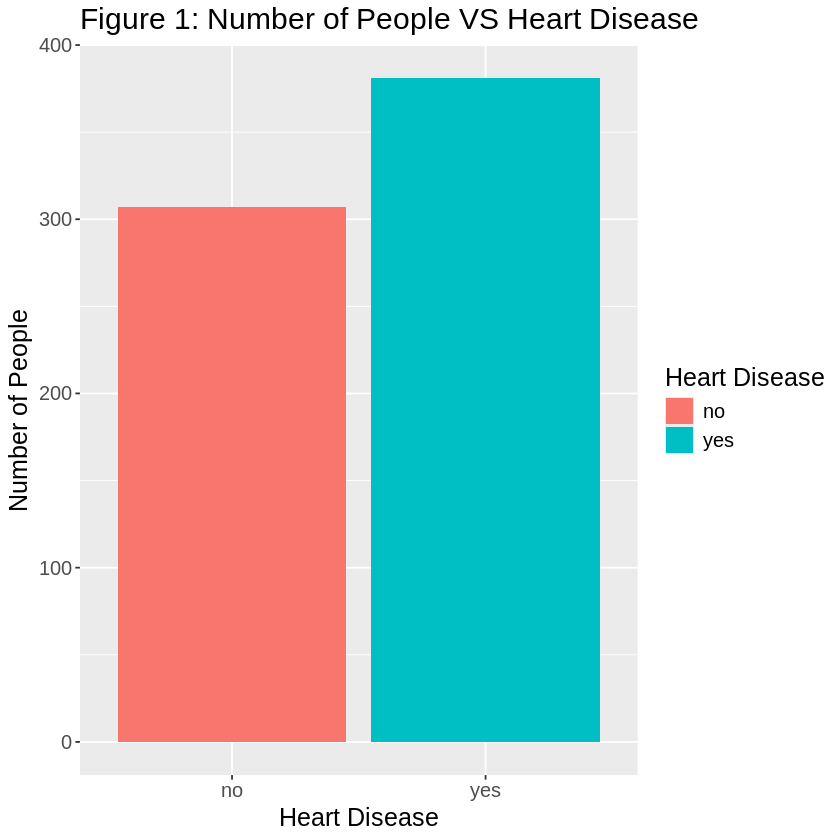

In [5]:
options(repr.plot.width = 7, repr.plot.height = 7) 
heart_disease_plot <- heart_train |>
    ggplot(aes(x = HeartDisease, fill = HeartDisease)) +
    geom_bar() +
    xlab("Heart Disease") +
    ylab("Number of People") +
    labs(fill = "Heart Disease") +
    ggtitle("Figure 1: Number of People VS Heart Disease") +
    theme(text = element_text(size = 15))

heart_disease_plot

Next, we need to build a model for k-nearest neighbor (k-nn) classification for each set of two categorical variables. To do this, we first set the seed again so that the nearest neighbors while tuning are always the same and hence this code is reproducible. Then, we determine the best k-value by performing 10-fold cross-validation for each set and using a workflow. We pull the best k-value which will be the one with the most accuracy.

In [28]:
set.seed(1)
# Finding the best k for predicting heart disease using Age and Resting Blood pressure as predictors
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 10, strata = HeartDisease)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

heart_recipe_Age_RestingBP <- recipe(HeartDisease ~ Age + RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_RestingBP_best_k <- workflow() |>
    add_recipe(heart_recipe_Age_RestingBP) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_RestingBP_best_k

[1] 81

In [29]:
# Finding the best k for predicting heart disease using Age and Cholesterol as predictors
heart_recipe_Age_Cholesterol <- recipe(HeartDisease ~ Age + Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_Age_Cholesterol) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_Cholesterol_best_k

[1] 36

In [30]:
# Finding the best k for predicting heart disease using Age and MaxHR as predictors
heart_recipe_Age_MaxHR <- recipe(HeartDisease ~ Age + MaxHR,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Age_MaxHR_best_k <- workflow() |>
    add_recipe(heart_recipe_Age_MaxHR) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
Age_MaxHR_best_k 

[1] 46

In [31]:
# Finding the best k for predicting heart disease using MaxHR and Cholesterol as predictors
heart_recipe_MaxHR_Cholesterol <- recipe(HeartDisease ~ MaxHR + Cholesterol,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

MaxHR_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_MaxHR_Cholesterol) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
MaxHR_Cholesterol_best_k 

[1] 66

In [32]:
# Finding the best k for predicting heart disease using MaxHR and RestingBP
heart_recipe_RestingBP_MaxHR <- recipe(HeartDisease ~ MaxHR + RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

RestingBP_MaxHR_best_k <- workflow() |>
    add_recipe(heart_recipe_RestingBP_MaxHR) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
RestingBP_MaxHR_best_k 

[1] 11

In [33]:
# Finding the best k for predicting heart disease using Cholesterol and RestingBP as predictors
heart_recipe_RestingBP_Cholesterol <- recipe(HeartDisease ~ Cholesterol + RestingBP,data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

RestingBP_Cholesterol_best_k <- workflow() |>
    add_recipe(heart_recipe_RestingBP_Cholesterol) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")|>
    arrange(desc(mean)) |>
    head(1) |>
    pull(neighbors)
RestingBP_Cholesterol_best_k 

[1] 86

Now, we use the best k-value that we found above in a new workflow. Then, using this workflow that we trained using the training dataset, we predict `HeartDisease` for the data present in the testing dataset. We also wanted to visualize the distribution using a scatterplot with different color for each categorical variable. We do this for each set.

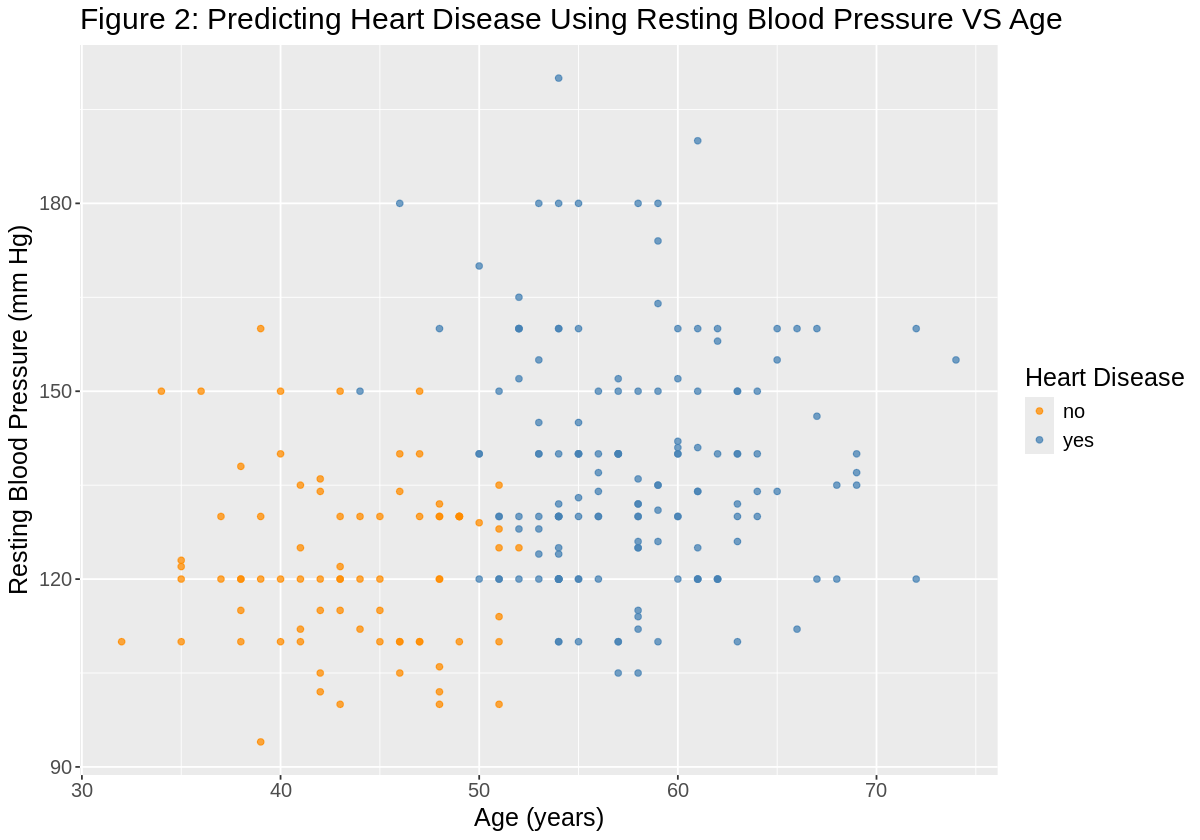

In [36]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_Age_RestingBP <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_RestingBP_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_RestingBP <- workflow() |>
        add_recipe(heart_recipe_Age_RestingBP) |>
        add_model(heart_spec_Age_RestingBP) |>
        fit(data = heart_train)

Heart_preds_Age_RestingBP <- heart_fit_Age_RestingBP |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_Age_RestingBP <- ggplot() +
  geom_point(data = Heart_preds_Age_RestingBP,
             mapping = aes(x = Age,
                           y = RestingBP,
                           color = .pred_class),
             alpha = 0.75) +
  labs(color = "Heart Disease",
       x = "Age (years)",
       y = "Resting Blood Pressure (mm Hg)") +
  ggtitle("Figure 2: Predicting Heart Disease Using Resting Blood Pressure VS Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 15))

heart_plot_Age_RestingBP

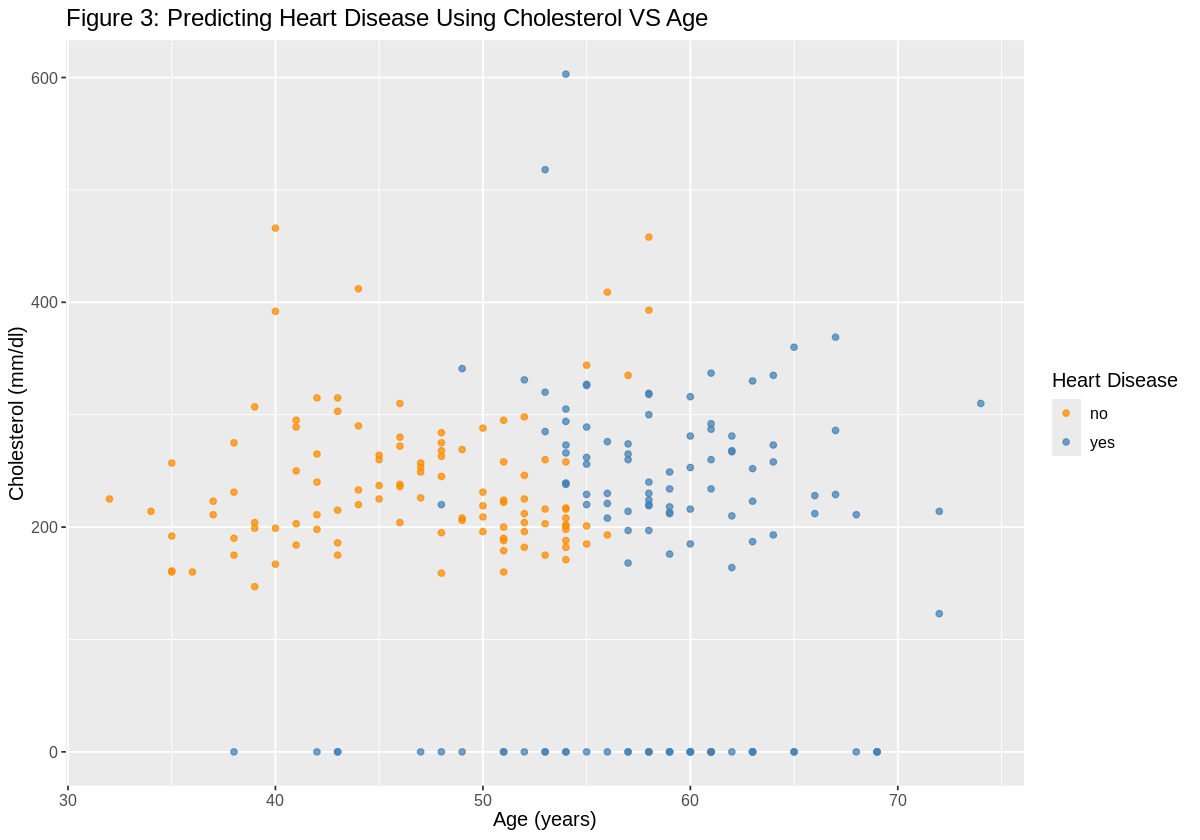

In [13]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_Age_Cholesterol <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_Cholesterol <- workflow() |>
        add_recipe(heart_recipe_Age_Cholesterol) |>
        add_model(heart_spec_Age_Cholesterol) |>
        fit(data = heart_train)

Heart_preds_Age_Cholesterol <- heart_fit_Age_Cholesterol |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_Age_Cholesterol <- ggplot() +
  geom_point(data = Heart_preds_Age_Cholesterol,
             mapping = aes(x = Age,
                           y = Cholesterol,
                           color = .pred_class),
             alpha = 0.75) +
  labs(color = "Heart Disease",
       x = "Age (years)",
       y = "Cholesterol (mm/dl)") +
  ggtitle("Figure 3: Predicting Heart Disease Using Cholesterol VS Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_Age_Cholesterol

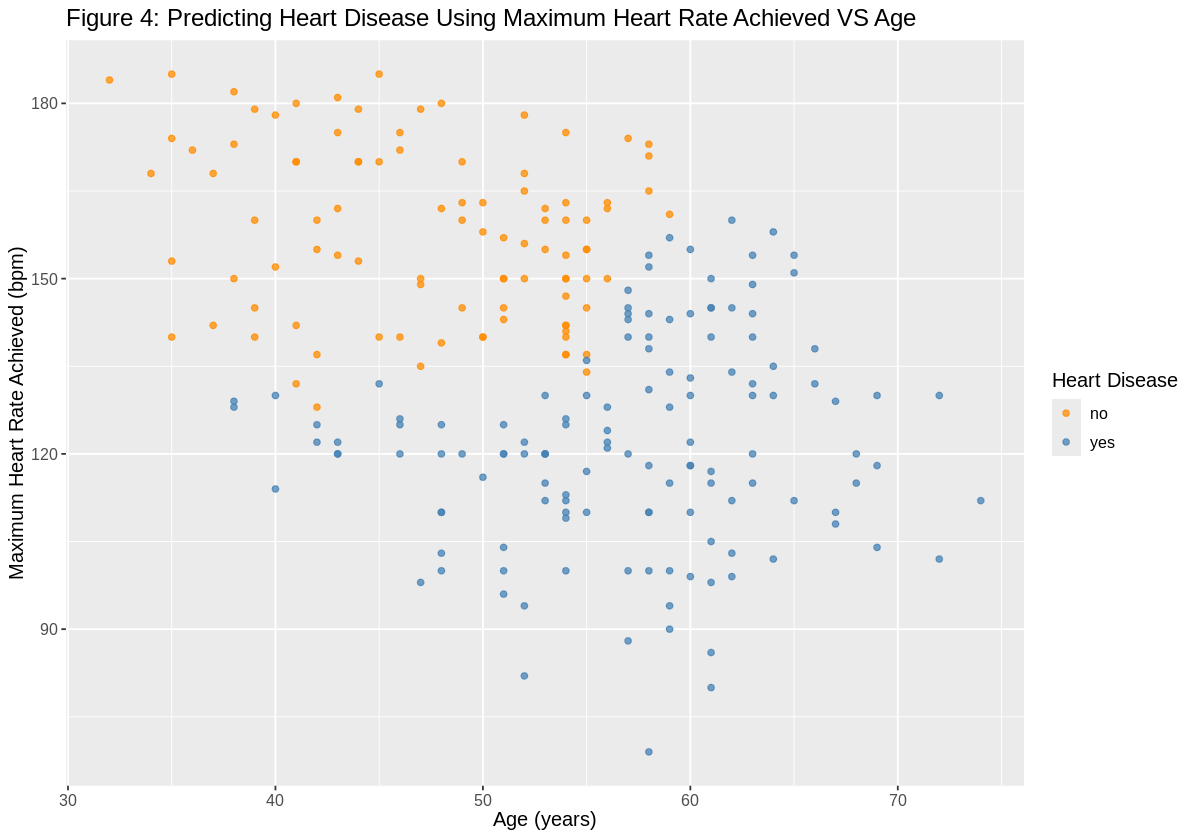

In [14]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_Age_MaxHR <- nearest_neighbor(weight_func = "rectangular", neighbors = Age_MaxHR_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_MaxHR <- workflow() |>
        add_recipe(heart_recipe_Age_MaxHR) |>
        add_model(heart_spec_Age_MaxHR) |>
        fit(data = heart_train)

Heart_preds_Age_MaxHR <- heart_fit_Age_MaxHR |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_Age_MaxHR <- ggplot() +
  geom_point(data = Heart_preds_Age_MaxHR,
             mapping = aes(x = Age,
                           y = MaxHR,
                           color = .pred_class),
             alpha = 0.75) +
  labs(color = "Heart Disease",
       x = "Age (years)",
       y = "Maximum Heart Rate Achieved (bpm)") +
  ggtitle("Figure 4: Predicting Heart Disease Using Maximum Heart Rate Achieved VS Age") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_Age_MaxHR

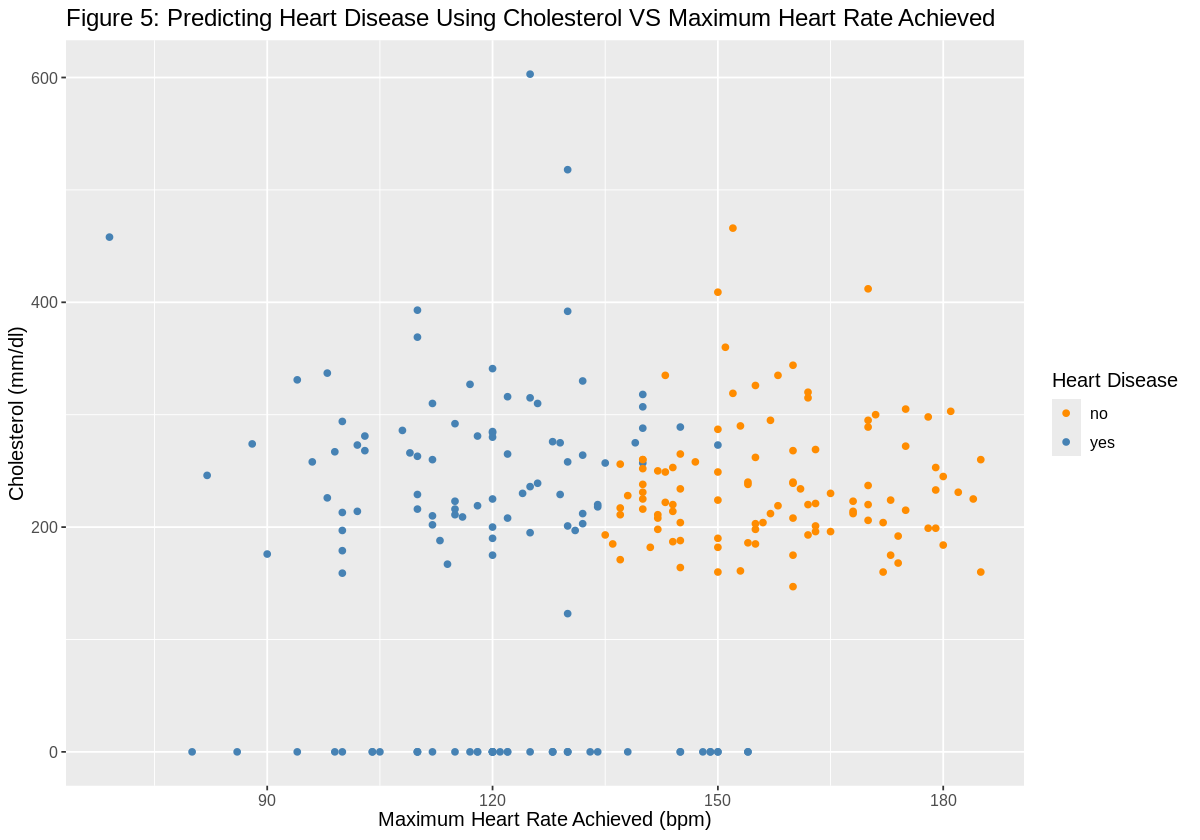

In [15]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_MaxHR_Cholesterol <- nearest_neighbor(weight_func = "rectangular", neighbors = MaxHR_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_Age_MaxHR <- workflow() |>
        add_recipe(heart_recipe_MaxHR_Cholesterol) |>
        add_model(heart_spec_MaxHR_Cholesterol) |>
        fit(data = heart_train)

Heart_preds_MaxHR_Cholesterol <- heart_fit_Age_MaxHR |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_MaxHR_Cholesterol <- ggplot() +
  geom_point(data = Heart_preds_MaxHR_Cholesterol,
             mapping = aes(x = MaxHR,
                           y = Cholesterol,
                           color = .pred_class)) +
  labs(color = "Heart Disease",
       x = "Maximum Heart Rate Achieved (bpm)",
       y = "Cholesterol (mm/dl)") +
  ggtitle("Figure 5: Predicting Heart Disease Using Cholesterol VS Maximum Heart Rate Achieved") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_MaxHR_Cholesterol

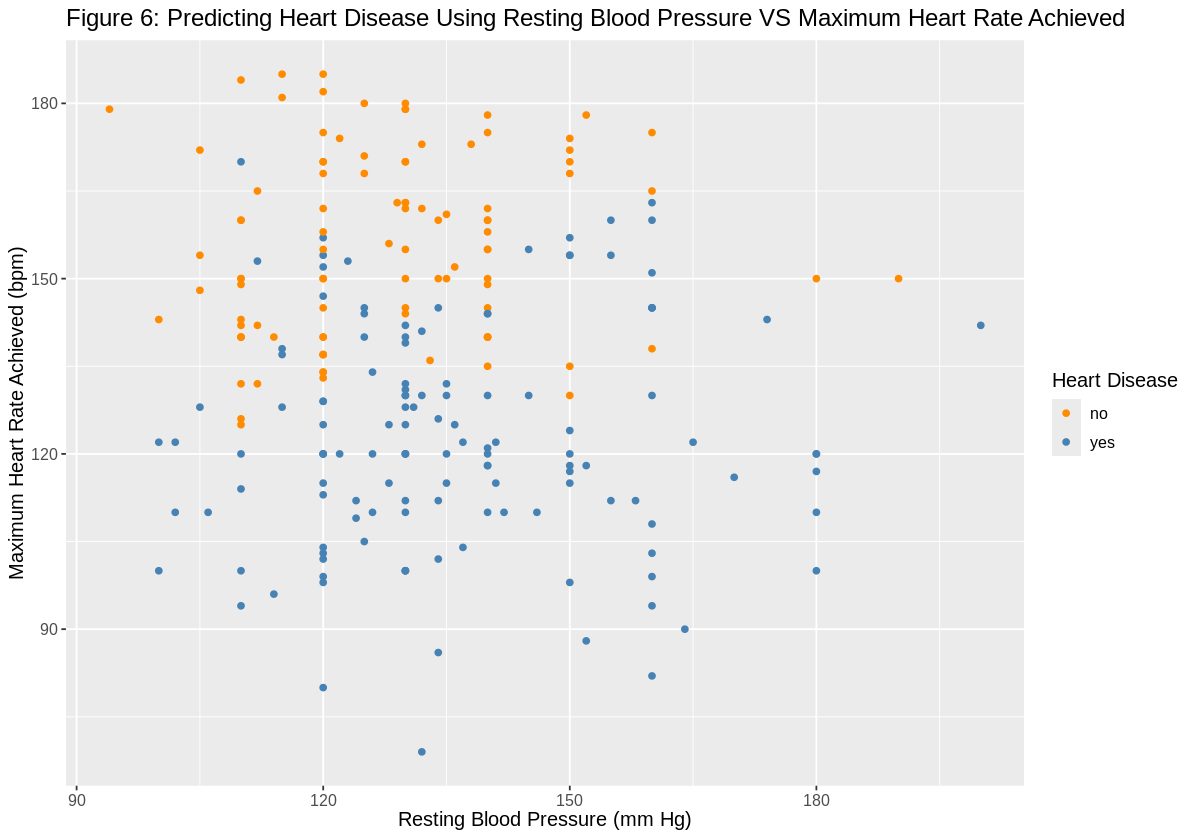

In [16]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_RestingBP_MaxHR <- nearest_neighbor(weight_func = "rectangular", neighbors = RestingBP_MaxHR_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_RestingBP_MaxHR <- workflow() |>
        add_recipe(heart_recipe_RestingBP_MaxHR) |>
        add_model(heart_spec_RestingBP_MaxHR) |>
        fit(data = heart_train)

Heart_preds_RestingBP_MaxHR <- heart_fit_RestingBP_MaxHR |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_RestingBP_MaxHR <- ggplot() +
  geom_point(data = Heart_preds_RestingBP_MaxHR,
             mapping = aes(x = RestingBP,
                           y = MaxHR,
                           color = .pred_class)) +
  labs(color = "Heart Disease",
       x = "Resting Blood Pressure (mm Hg)",
       y = "Maximum Heart Rate Achieved (bpm)") +
  ggtitle("Figure 6: Predicting Heart Disease Using Resting Blood Pressure VS Maximum Heart Rate Achieved") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))

heart_plot_RestingBP_MaxHR

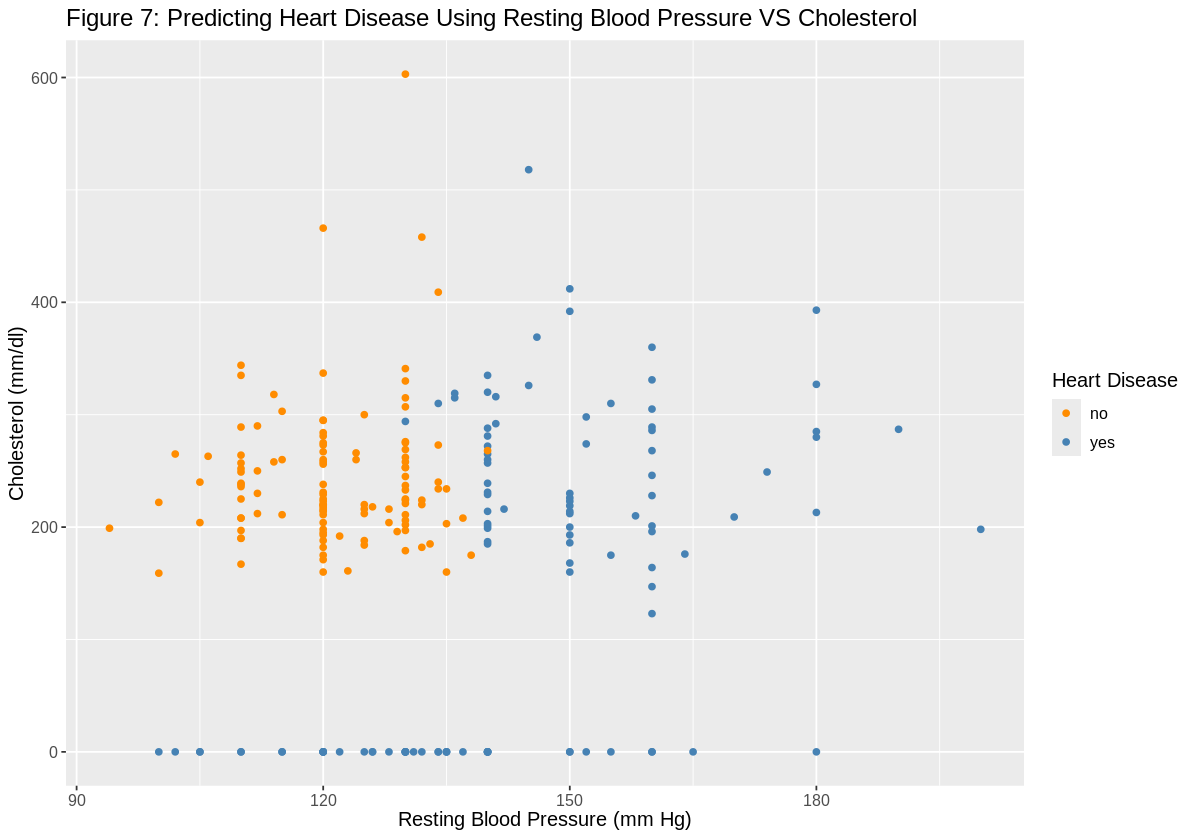

In [17]:
options(repr.plot.width = 10, repr.plot.height = 7) 
heart_spec_RestingBP_Cholesterol <- nearest_neighbor(weight_func = "rectangular", neighbors = RestingBP_Cholesterol_best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_fit_RestingBP_Cholesterol <- workflow() |>
        add_recipe(heart_recipe_RestingBP_Cholesterol) |>
        add_model(heart_spec_RestingBP_Cholesterol) |>
        fit(data = heart_train)

Heart_preds_RestingBP_Cholesterol <- heart_fit_RestingBP_Cholesterol |>
        predict(heart_test) |>
        bind_cols(heart_test)

heart_plot_RestingBP_Cholesterol <- ggplot() +
  geom_point(data = Heart_preds_RestingBP_Cholesterol,
             mapping = aes(x = RestingBP,
                           y = Cholesterol,
                           color = .pred_class)) +
  labs(color = "Heart Disease",
       x = "Resting Blood Pressure (mm Hg)",
       y = "Cholesterol (mm/dl)") +
  ggtitle("Figure 7: Predicting Heart Disease Using Resting Blood Pressure VS Cholesterol") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 12))
heart_plot_RestingBP_Cholesterol

Next, we will calculate the accuracies, recall and precisions for each model to determine which of these are good predictors and which of these are not.

In [61]:
accuracy_Age_RestingBP <- Heart_preds_Age_RestingBP |>
    metrics(truth = HeartDisease, estimate = .pred_class) |>
    bind_rows(recall(Heart_preds_Age_RestingBP, truth=HeartDisease, estimate=.pred_class)) |>
    bind_rows(precision(Heart_preds_Age_RestingBP, truth=HeartDisease, estimate=.pred_class)) |>
    select(.metric, .estimate) |>
    filter(.metric != "kap")

accuracy_Age_Cholesterol <- Heart_preds_Age_Cholesterol |>
    metrics(truth = HeartDisease, estimate = .pred_class) |>
    bind_rows(recall(Heart_preds_Age_Cholesterol, truth=HeartDisease, estimate=.pred_class)) |>
    bind_rows(precision(Heart_preds_Age_Cholesterol, truth=HeartDisease, estimate=.pred_class)) |>
    select(.metric, .estimate) |>
    filter(.metric != "kap")

accuracy_Age_MaxHR <- Heart_preds_Age_MaxHR |>
    metrics(truth = HeartDisease, estimate = .pred_class) |>
    bind_rows(recall(Heart_preds_Age_MaxHR, truth=HeartDisease, estimate=.pred_class)) |>
    bind_rows(precision(Heart_preds_Age_MaxHR, truth=HeartDisease, estimate=.pred_class)) |>
    select(.metric, .estimate) |>
    filter(.metric != "kap")

accuracy_MaxHR_Cholesterol <- Heart_preds_MaxHR_Cholesterol |>
    metrics(truth = HeartDisease, estimate = .pred_class) |>
    bind_rows(recall(Heart_preds_MaxHR_Cholesterol, truth=HeartDisease, estimate=.pred_class)) |>
    bind_rows(precision(Heart_preds_MaxHR_Cholesterol, truth=HeartDisease, estimate=.pred_class)) |>
    select(.metric, .estimate) |>
    filter(.metric != "kap")

accuracy_RestingBP_MaxHR <- Heart_preds_RestingBP_MaxHR |>
    metrics(truth = HeartDisease, estimate = .pred_class) |>
    bind_rows(recall(Heart_preds_RestingBP_MaxHR, truth=HeartDisease, estimate=.pred_class)) |>
    bind_rows(precision(Heart_preds_RestingBP_MaxHR, truth=HeartDisease, estimate=.pred_class)) |>
    select(.metric, .estimate) |>
    filter(.metric != "kap")


accuracy_RestingBP_Cholesterol <- Heart_preds_RestingBP_Cholesterol |>
    metrics(truth = HeartDisease, estimate = .pred_class) |>
    bind_rows(recall(Heart_preds_RestingBP_Cholesterol, truth=HeartDisease, estimate=.pred_class)) |>
    bind_rows(precision(Heart_preds_RestingBP_Cholesterol, truth=HeartDisease, estimate=.pred_class)) |>
    select(.metric, .estimate) |>
    filter(.metric != "kap")


accuracy_Age_RestingBP
accuracy_Age_Cholesterol
accuracy_Age_MaxHR
accuracy_MaxHR_Cholesterol
accuracy_RestingBP_MaxHR
accuracy_RestingBP_Cholesterol

.metric,.estimate
<chr>,<dbl>
accuracy,0.6391304
recall,0.4757282
precision,0.6282051


.metric,.estimate
<chr>,<dbl>
accuracy,0.7130435
recall,0.6990291
precision,0.6728972


.metric,.estimate
<chr>,<dbl>
accuracy,0.7391304
recall,0.6796117
precision,0.7216495


.metric,.estimate
<chr>,<dbl>
accuracy,0.7000000
recall,0.6796117
precision,0.6603774


.metric,.estimate
<chr>,<dbl>
accuracy,0.6347826
recall,0.5728155
precision,0.5959596


.metric,.estimate
<chr>,<dbl>
accuracy,0.6565217
recall,0.6893204
precision,0.6016949


From the accuarcies above we can see that each model has different accuracies. We can see that when we use `Age` and `MaxHR` as predictors the accuracy, precision and recall is higher compared to others. We can see that predictors such as `RestingBP` have lesser correlation to `HeartDisease`. From the above tables, we can conclude that when we use `Age` and `MaxHR` or when we use `MaxHR` and `Cholesterol` as predictors we get higher accuracies, precision and recall. We can also conclude that `MaxHR` is most likely the best predictor out of all while `RestingBP` is not such a good predictor.

Now we will create a classification model using all the predictors together in the model. From Figure 1, we see above that in the training set there are roughly an equal number of positive and negative test results, so we can go ahead with creating the model.

First we will create a workflow to find the best K value for the model. We will use cross-validation with 5 folds. We will also create a recipe to scale and center all the predictors to ensure all variables are weighted equally. Again we set the seed so that this code is reproducible.

In [47]:
# classification for all predictors: picking the best k
# set the seed
set.seed(1234) 

# creating the recipe and model specifications
heart_recipe <- recipe(HeartDisease ~., data = heart_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

heart_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")


# vfold model
vfold <- vfold_cv(heart_train, v = 5, strata = HeartDisease)

# k testing values
k_vals <- tibble(neighbors = seq(from = 2, to = 50, by = 1))


#creating the workflow
results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_train) |>
    tune_grid(resamples = vfold, grid = k_vals) |>
    collect_metrics()

Warning message:
“tune samples were requested but there were 688 rows in the data. 683 will be used.”


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6481052,5,0.014761377,Preprocessor1_Model01
3,accuracy,binary,0.6599205,5,0.009200394,Preprocessor1_Model02
4,accuracy,binary,0.6599205,5,0.009200394,Preprocessor1_Model03
5,accuracy,binary,0.6670724,5,0.010704971,Preprocessor1_Model04
6,accuracy,binary,0.6670724,5,0.010704971,Preprocessor1_Model05
7,accuracy,binary,0.6714730,5,0.008725464,Preprocessor1_Model06
8,accuracy,binary,0.6714730,5,0.008725464,Preprocessor1_Model07
9,accuracy,binary,0.6802215,5,0.008941575,Preprocessor1_Model08
10,accuracy,binary,0.6802215,5,0.008941575,Preprocessor1_Model09


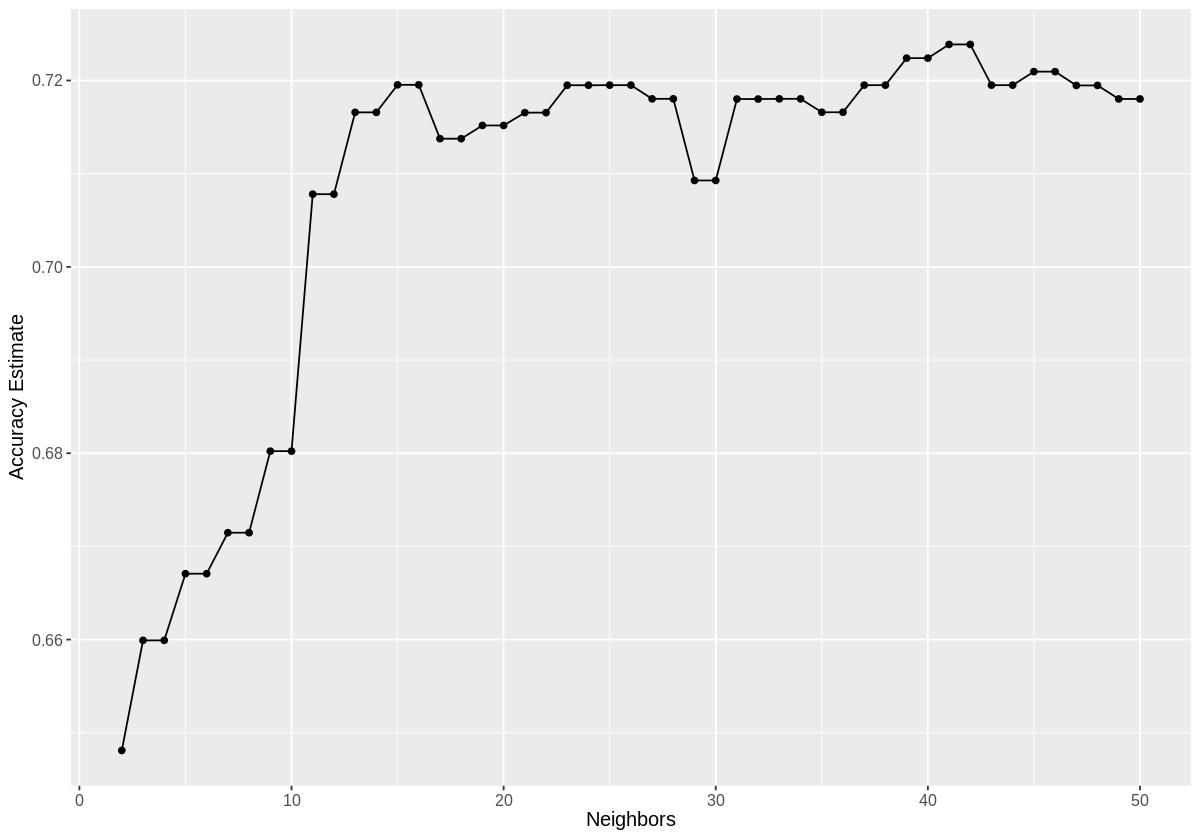

In [63]:
set.seed(1234)
accuracies <- results |>
  filter(.metric == "accuracy")

accuracies

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

cross_val_plot

We can now pull the best K to find what will give us the greatest accuracy. We can also just look at the graph above and see which nieghbor has the highest accuracy.

In [21]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 41

We know that the accuracy when using the training data is around 73% for K = 41. We know this is the greatest accuracy so we can now build our final model with K = 41.

In [22]:
# building the model

# set the seed
set.seed(1234) 
    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 41) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_fit <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(knn_spec) |>
       fit(data = heart_train)

heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(41,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2761628
Best kernel: rectangular
Best k: 41

## Results

We can now apply the final model to the testing set of data and see how it performs.

In [50]:
heart_test_predictions <- predict(heart_fit, heart_test) |>
       bind_cols(heart_test)

We can now find the accuracy of our model on the testing set to determine how good the model is.

In [60]:
# accuracy
heart_prediction_accuracy <- heart_test_predictions |>
         metrics(truth = HeartDisease, estimate = .pred_class) |>
         filter(.metric != "kap")
heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7347826


We can now create a confusion matrix which tells us how many of the test set labels of each type are predicted correctly and incorrectly. This can help give us more detail about the kinds of mistakes the classifier tends to make.

In [45]:
# confusion matrix
heart_matrix <- heart_test_predictions |> 
       conf_mat(truth = HeartDisease, estimate = .pred_class)
heart_matrix

          Truth
Prediction no yes
       no  74  32
       yes 29  95

Table 1

In [26]:
#calculates the accuracy of the model
accuracy <- (72+97)/(72+97+30+31)
accuracy

[1] 0.7347826

We can also find other performance metrics including recall and precision to get a better sense of how the model performs.

In [59]:
# performance metrics
heart_metrics <- metrics(heart_test_predictions, truth=HeartDisease, estimate=.pred_class) |>
    bind_rows(recall(heart_test_predictions, truth=HeartDisease, estimate=.pred_class)) |>
    bind_rows(precision(heart_test_predictions, truth=HeartDisease, estimate=.pred_class)) |>
    filter(.metric != "kap")

heart_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7347826
recall,binary,0.7184466
precision,binary,0.6981132


## Discussion:

### Summary

Through our methods, we have found that `Age` plays a significant role in heart disease patients, and as a person's age increases, they are more likely to develop heart disease. This can be seen in the graphs `heart_plot_Age_Cholesterol` and `heart_plot_Age_RestingBP`. In these graphs, `Age` is on the x-axis, and `Cholesterol` or `RestingBP` is on the y-axis. There is no correlation on the y-axis for both graphs. However, on the x-axis, as soon as the `Age` passes 50 years, heart disease begins to present. In `heart_plot_Age_MaxHR`, there appears to be a moderate negative correlation, meaning that as `Age` increases on the x-axis and `MaxHR` decreases on the y-axis, more cases of heart disease present themselves. In the first graph without age on the x-axis, `heart_plot_MaxHR_Cholesterol`, `MaxHR` is on the x-axis, and it is seen that once the heart rate passes ~130 beats per minute, heart disease becomes unlikely. Meanwhile, cholesterol still plays no role as there is no correlation. In the subsequent `heart_plot_RestingBP_MaxHR plot`, the previous idea that once the heart rate passes ~130 beats per minute, heart disease becomes unlikely, is supported. Also, `RestingBP` still plays no role. In the final graph, `heart_plot_RestingBP_Cholesterol`, there is no correlation that can be seen as there is a significant overlap of both points. These graphs make it clear that the only two factors that can be considered significant in predicting heart disease are `Age` and `MaxHR`.

Though our results we are able to see that our model is not entirely accurate and rather it has had 30 & 31 false negatives and false positives. Using the formula:

$${accuracy} = \frac{\mathrm{number \; of \; correct \; predictions}}{\mathrm{total \; number \; of \; predictions}} = \frac{72+97}{72+97+31+30} = 0.735.$$
it is seen that the accuracy of our model is 73.5% which is not great but better than others. However on the medical scence we would want our classification model to be stronger as an inaccuarcy of 26.5% is very significant. In practice this would mean that out of 100 people nearly 27 people would be misdiagnosed. To improve this we could train our model with more data, we could also have the model use cross validation. 


The results found in the above study generally answer our initial research question, posed as "**can we predict if a patient has heart disease based on their age, resting blood pressure, serum cholesterol, and maximum resting heart rate?**". It seems as though measured `Cholesterol` and `RestingBP` play little role in the presence of heart disease, while factors such as `Age` and `MaxHR` play a significant role. While this does answer the research question, it is surprising that some of the variables in the dataset played little role in the presence of heart disease (i.e., `Cholesterol` and `RestingBP`, traditionally viewed as factors potentially increasing rate of heart disease). Further research or data analysis might be necessary to completely rule out the effects of these factors on heart health. 

The impact of these findings is profound for the treatment of heart disease. Knowing that these factors play a critical role in the presence of heart disease, doctors can be on the lookout for patients with concerning vitals. Furthermore, this research elucidates that `Cholesterol` and `RestingBP` play less of a role in the presence of heart disease, allowing doctors to be less concerned with certain patients. 

Understanding the results of our analysis, further questions can be drawn:

- "If `Cholesterol` and `RestingBP` don't increase the rates of heart disease, do they have any other effects on the body?"
- "Does the biological background (Northern European, Southern European, Subsaharan African, Indigenous, etc.) of an individual affect the rates of heart disease, potentially by increasing certain risk factors?"
- "If we can now identify patients with potential heart disease, what is the greatest corrective measure one can take to vastly improve their heart health?"
- "Does geographical location play a role in heart health? Are those in third world countries at higher risk or more predisposed towards heart disease than those in first world countries?"

Overall, this study effectively answered our research question, opening doors to improved patient care and potentially lowering mortality within the general population due to heart disease.


## References

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

World Health Organization. (2023). *Cardiovascular Diseases*. World Health Organization. https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1